In [48]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [33]:
df = pd.read_csv ('https://github.com/YBIFoundation/Dataset/raw/main/Stars.csv')
df.head()

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star type,Star category,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,0,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,0,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,0,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,0,Brown Dwarf,Red,M


In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity (L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius (R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude (Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


In [35]:
y_col = 'Star type'

X = df.drop(y_col, axis=1)
y = df[y_col]

# trsform the target variable to classification problem


numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes('object').columns.tolist()

assert len(numerical_features) + len(categorical_features) == X.shape[1], 'all columns should be accounted for'

In [36]:
# Pipeline per le feature numeriche (imputazione + normalizzazione)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline per le feature categoriche (one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinazione delle trasformazioni
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [37]:
# Pipeline for labels
label_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione delle trasformazioni ai dati
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Trasformazione di y in categorico
y_train = label_transformer.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test = label_transformer.transform(y_test.values.reshape(-1, 1)).toarray()


In [39]:
# Definizione del modello
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    # Dense(64, activation='relu'),
    # Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer per la classificazione multiclasse
])




c:\Users\vinor\Desktop\Develhope\projects\EDU-ArtificialNeuralNetworks\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
metrics=['accuracy', Precision(name="precision"), Recall(name="recall"), AUC(name="auc")]

# Compilazione del modello
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [41]:
# Callback per l'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [42]:
# Addestramento del modello
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # Numero massimo di epoche
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.1617 - auc: 0.4927 - loss: 1.8285 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2564 - val_auc: 0.5892 - val_loss: 1.7365 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2969 - auc: 0.6533 - loss: 1.6773 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3846 - val_auc: 0.7715 - val_loss: 1.5845 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4043 - auc: 0.8256 - loss: 1.5297 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6154 - val_auc: 0.8837 - val_loss: 1.4423 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6745 - auc: 0.9261 - loss: 1.3835 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7949 - val_auc: 0.9356 - val_loss: 1.3108 - val_precision: 0.0000e+00 

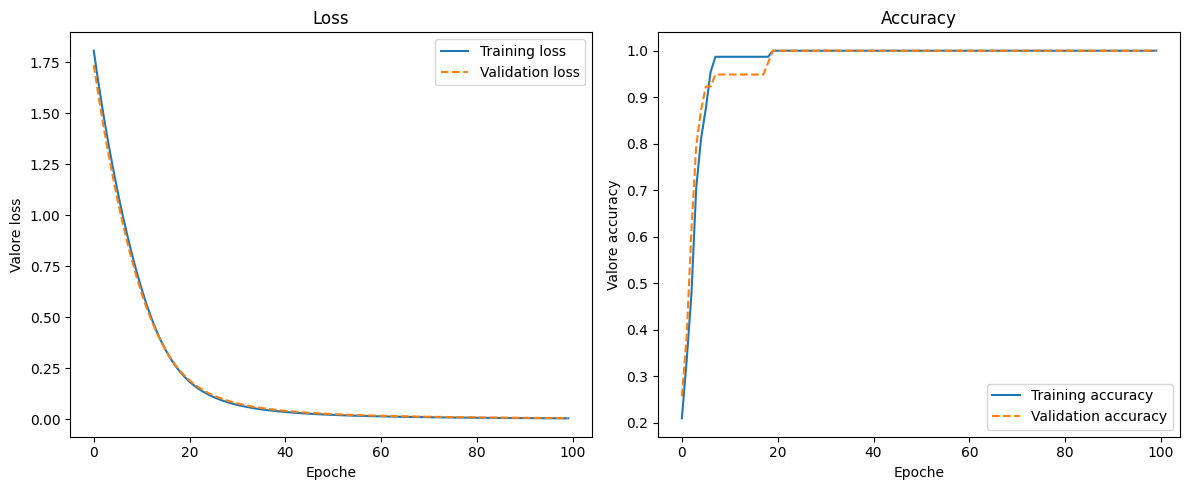

In [43]:
# Esempio di visualizzazione di loss e accuracy
plt.figure(figsize=(12, 5))

# Plot della loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss', linestyle='--')
plt.title('Loss')
plt.xlabel('Epoche')
plt.ylabel('Valore loss')
plt.legend()

# Plot dell'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', linestyle='--')
plt.title('Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Valore accuracy')
plt.legend()

plt.tight_layout()
plt.show()


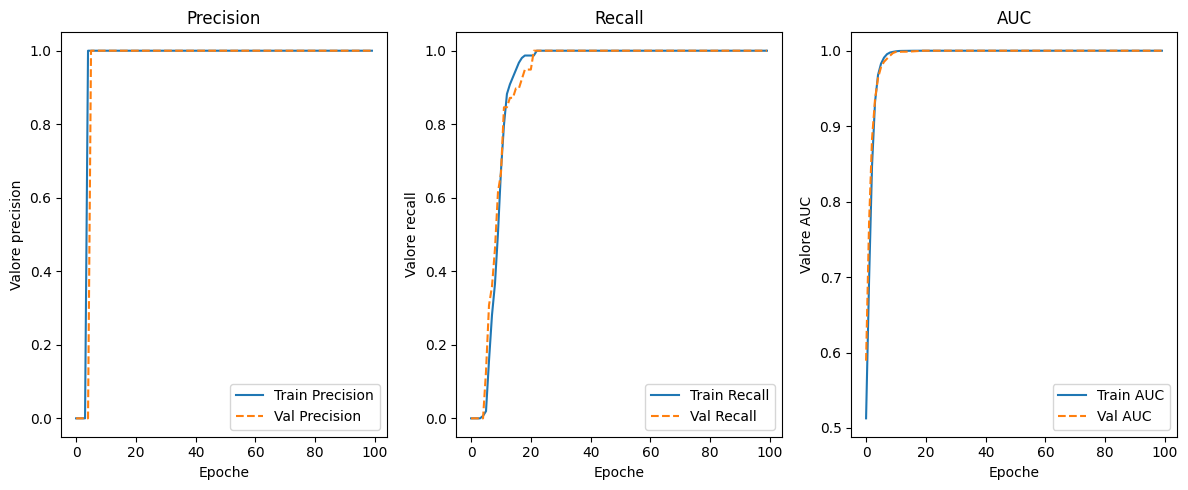

In [44]:
# Precision
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision', linestyle='--')
plt.title('Precision')
plt.xlabel('Epoche')
plt.ylabel('Valore precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall', linestyle='--')
plt.title('Recall')
plt.xlabel('Epoche')
plt.ylabel('Valore recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC', linestyle='--')
plt.title('AUC')
plt.xlabel('Epoche')
plt.ylabel('Valore AUC')
plt.legend()

plt.tight_layout()
plt.show()


In [55]:
y_pred_prob = model.predict(X_test)         # shape: (n_campioni, 6)
y_pred = np.argmax(y_pred_prob, axis=1)     # shape: (n_campioni,)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [56]:
y_test_labels = np.argmax(y_test, axis=1)
y_test_labels



array([2, 0, 3, 4, 4, 5, 5, 2, 0, 2, 4, 2, 5, 4, 5, 5, 0, 1, 3, 0, 0, 1,
       5, 3, 5, 3, 1, 2, 5, 3, 3, 4, 2, 0, 1, 0, 1, 5, 1, 5, 4, 5, 4, 1,
       3, 0, 4, 3], dtype=int64)

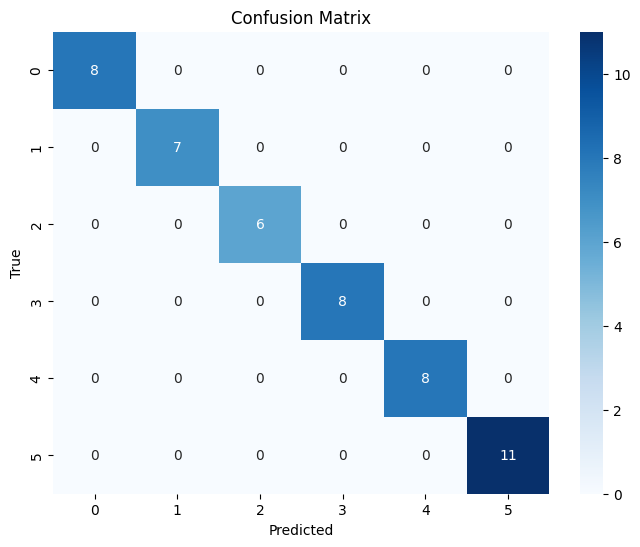

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        11

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



In [58]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4,5], 
            yticklabels=[0,1,2,3,4,5])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))
